## Trying out a linear model: 

Author: Alexandru Papiu ([@apapiu](https://twitter.com/apapiu), [GitHub](https://github.com/apapiu))
 
If you use parts of this notebook in your own scripts, please give some sort of credit (for example link back to this). Thanks!


There have been a few [great](https://www.kaggle.com/comartel/house-prices-advanced-regression-techniques/house-price-xgboost-starter/run/348739)  [scripts](https://www.kaggle.com/zoupet/house-prices-advanced-regression-techniques/xgboost-10-kfolds-with-scikit-learn/run/357561) on [xgboost](https://www.kaggle.com/tadepalli/house-prices-advanced-regression-techniques/xgboost-with-n-trees-autostop-0-12638/run/353049) already so I'd figured I'd try something simpler: a regularized linear regression model. Surprisingly it does really well with very little feature engineering. The key point is to to log_transform the numeric variables since most of them are skewed.

In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [222]:
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")
ids = test['Id']

In [223]:
train.shape

(1460, 81)

In [224]:
test.shape

(1459, 80)

In [225]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [226]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

###Data preprocessing: 
We're not going to do anything fancy here: 
 
- First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal    
- Create Dummy variables for the categorical features    
- Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x123a63f28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1259dfe80>]], dtype=object)

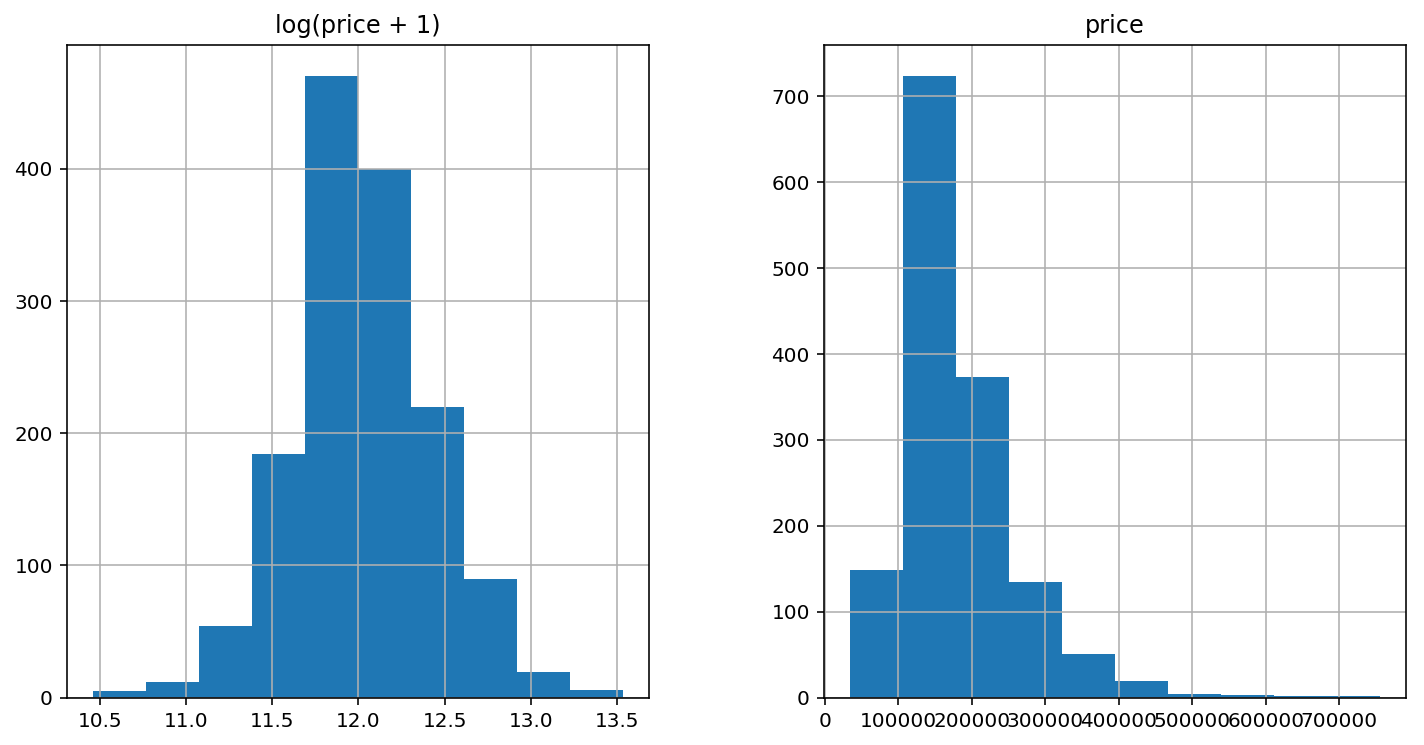

In [227]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [228]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [229]:
all_data = pd.get_dummies(all_data)
# 还有标题

In [230]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [231]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice
print(type(X_test))
print(X_test.shape)
# 还有标题
# print("X_train",X_train)
# print("X_test",X_test)

<class 'pandas.core.frame.DataFrame'>
(1459, 288)


In [232]:
print(X_train.shape)
print(X_test.shape)
print(y.shape)


(1460, 288)
(1459, 288)
(1460,)


###Models

Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [233]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [234]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [235]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

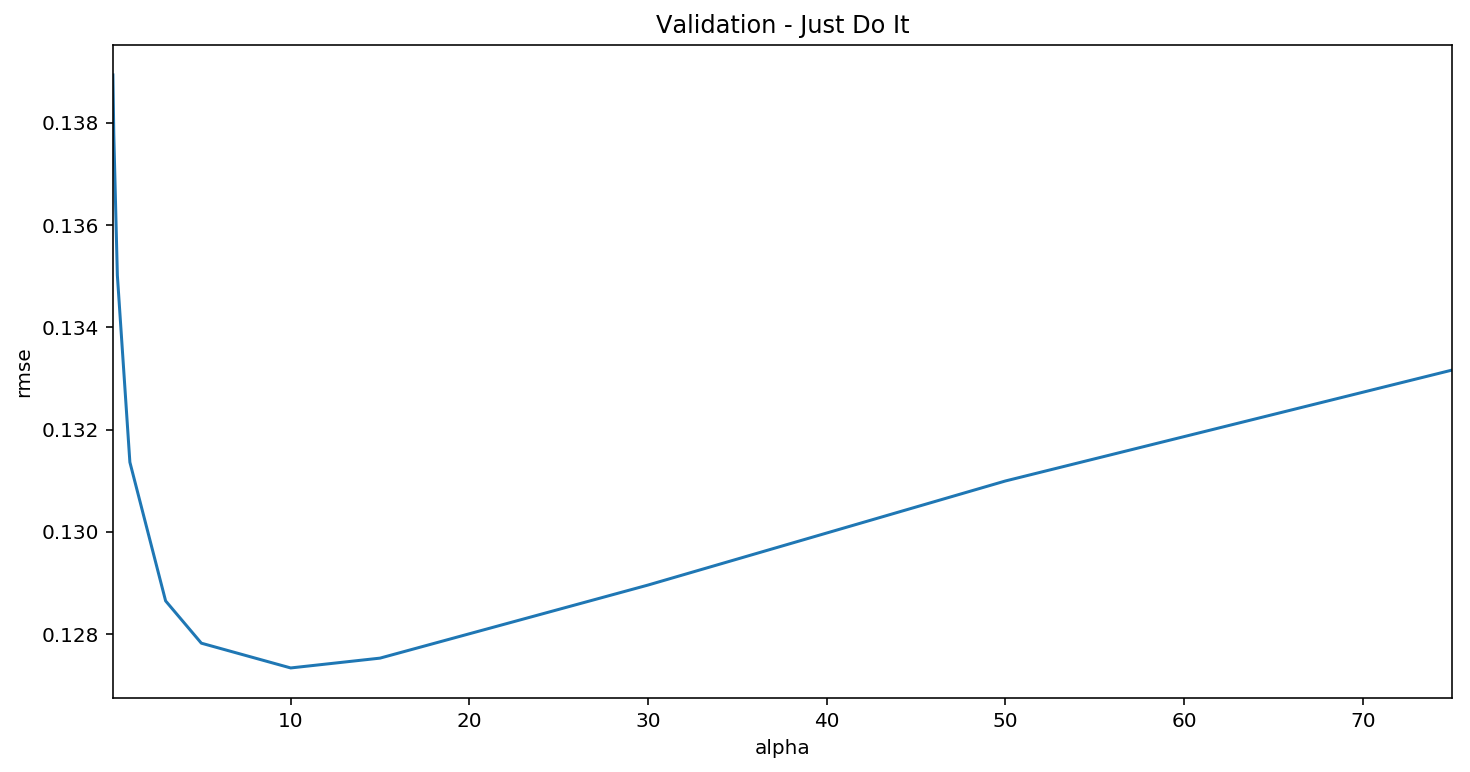

In [236]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [237]:
cv_ridge.min()

0.12733734668670763

So for the Ridge regression we get a rmsle of about 0.127

Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [238]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [239]:
rmse_cv(model_lasso).mean()

0.12314421090977448

Nice! The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [240]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [241]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 111 variables and eliminated the other 177 variables


Good job Lasso.  One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [242]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

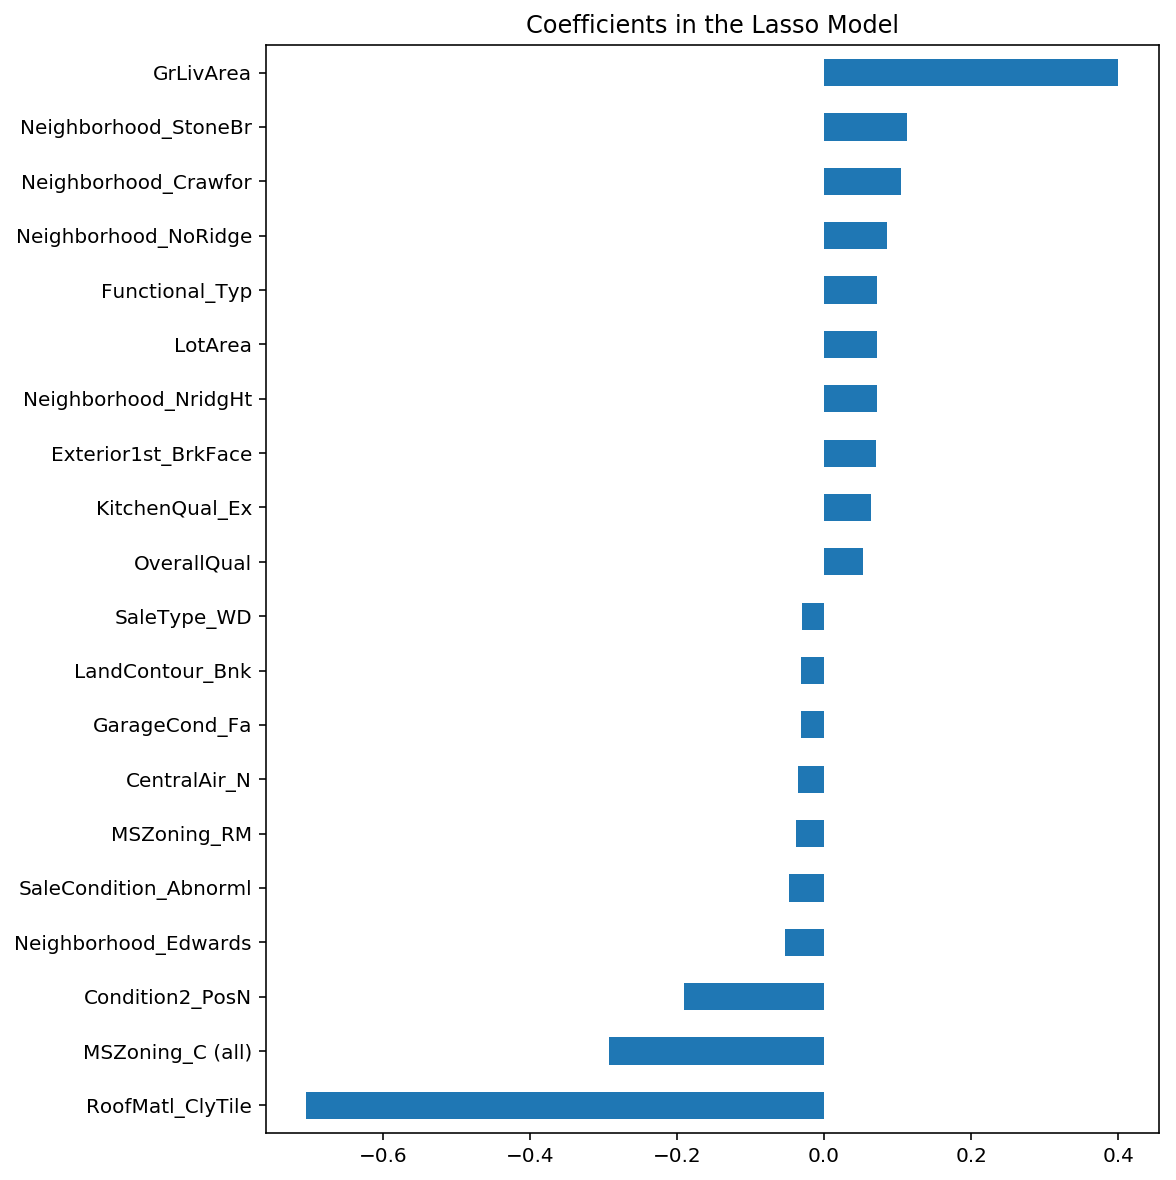

In [243]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is `GrLivArea` -  the above ground area by area square feet. This definitely sense. Then a few other  location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

 Also note that unlike the feature importance you'd get from a random forest these are _actual_ coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret. 

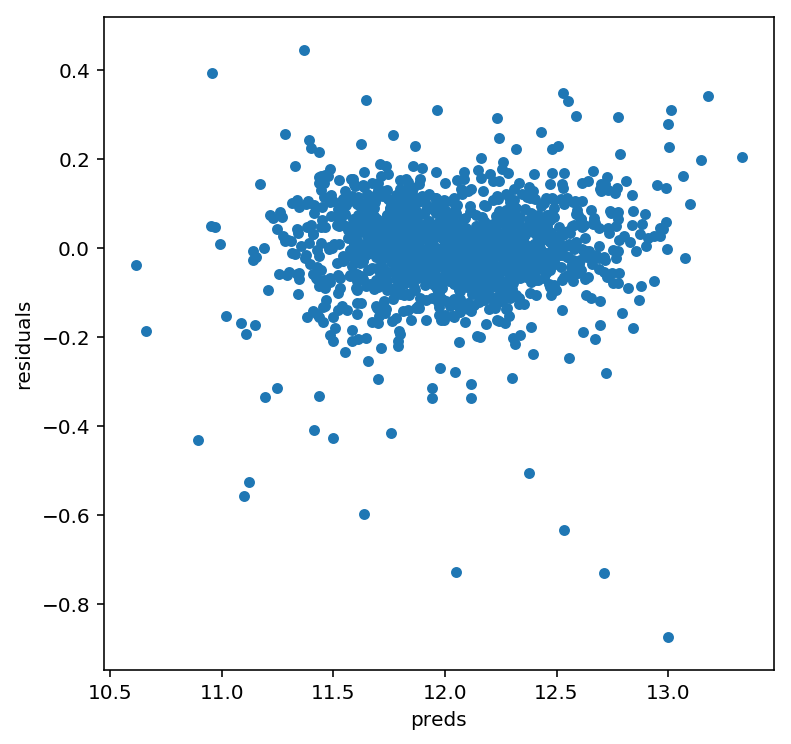

In [244]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

The residual plot looks pretty good.To wrap it up let's predict on the test set and submit on the leaderboard:

### Adding an xgboost model:

Let's add an xgboost model to our linear model to see if we can improve our score:

In [245]:
import xgboost as xgb

In [246]:
# print(X_train)
# 还有标题
dtrain = xgb.DMatrix(X_train, label = y)

dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)
# print(X_train)
# 还有标题

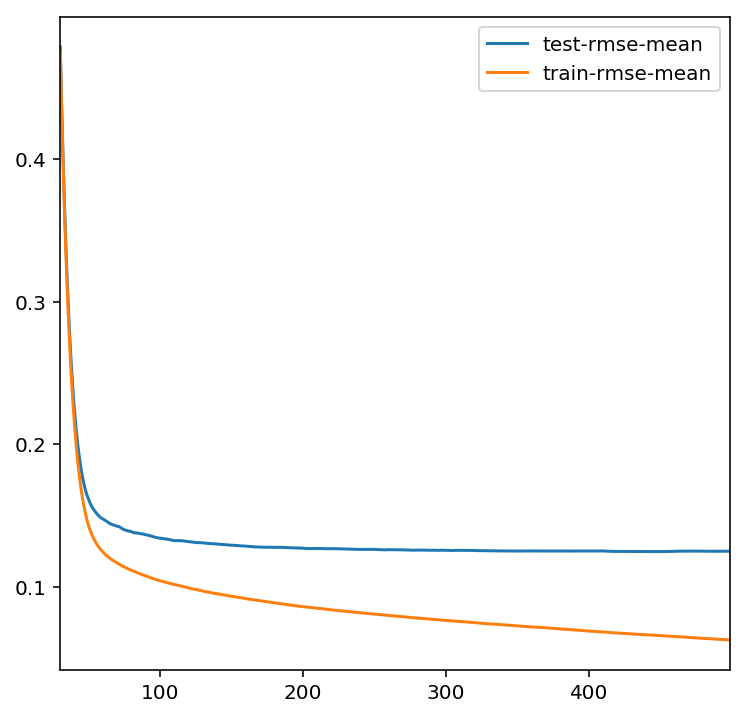

In [247]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
# 还有标题
# print(X_train)

In [248]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)
# 还有标题
# print(X_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [249]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))
# 还有标题
# print(X_train)

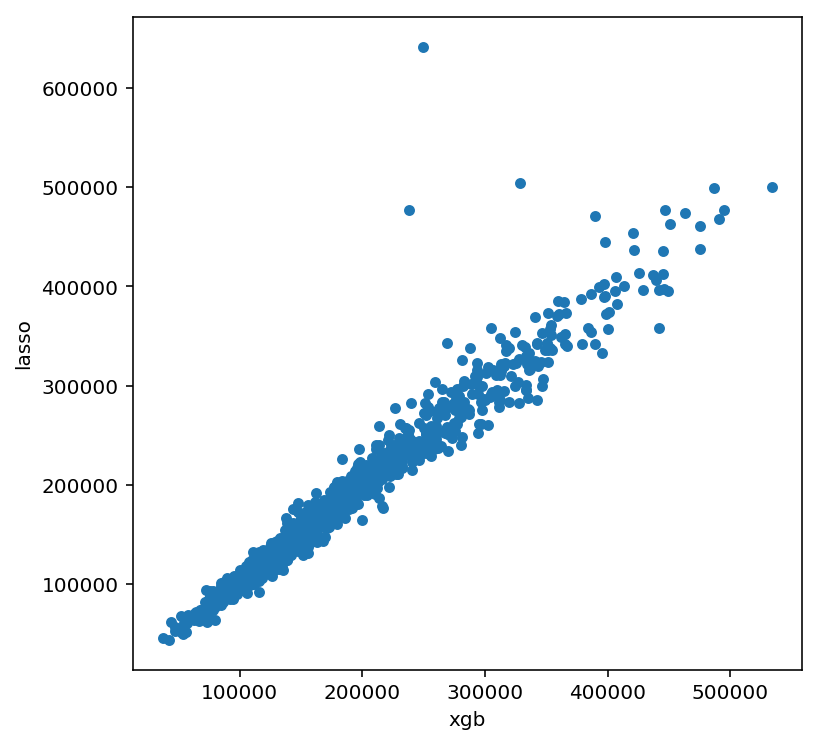

In [250]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")
# 还有标题
# print(X_train)

Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves the score although in this case it doesn't help that much.

In [251]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [252]:
# 还有标题
# print(X_train)
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)


      MSSubClass  LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
0       4.110874     4.189655   9.042040            7            5       2003   
1       3.044522     4.394449   9.169623            6            8       1976   
2       4.110874     4.234107   9.328212            7            5       2001   
3       4.262680     4.110874   9.164401            7            5       1915   
4       4.110874     4.442651   9.565284            8            5       2000   
5       3.931826     4.454347   9.555064            5            5       1993   
6       3.044522     4.330733   9.218804            8            5       2004   
7       4.110874     4.196175   9.247925            7            6       1973   
8       3.931826     3.951244   8.719481            7            5       1931   
9       5.252273     3.931826   8.912069            5            6       1939   
10      3.044522     4.262680   9.323758            5            5       1965   
11      4.110874     4.45434

### Trying out keras?

Feedforward Neural Nets doesn't seem to work well at all...I wonder why.

In [253]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [276]:
# 有标题
print(type(X_train))
X_train.to_csv('./out1.csv')
X_train_ss = StandardScaler().fit_transform(X_train)
X_train_ss_pd = pd.DataFrame(X_train_ss)
X_train_ss_pd.to_csv('./out2.csv')
# 从此无标题
print(X_train_ss)

<class 'pandas.core.frame.DataFrame'>
[[ 0.42446233 -0.04942222 -0.13327022 ..., -0.11785113  0.4676514
  -0.30599503]
 [-1.12520184  0.60296111  0.11341289 ..., -0.11785113  0.4676514
  -0.30599503]
 [ 0.42446233  0.0921812   0.42004913 ..., -0.11785113  0.4676514
  -0.30599503]
 ..., 
 [ 0.64507285 -0.00151827 -0.00235902 ..., -0.11785113  0.4676514
  -0.30599503]
 [-1.12520184  0.0921812   0.13683278 ..., -0.11785113  0.4676514
  -0.30599503]
 [-1.12520184  0.39999105  0.18011644 ..., -0.11785113  0.4676514
  -0.30599503]]


In [397]:
print(type(X_train))
from sklearn.feature_selection import SelectKBest,f_regression
# X_train_new = SelectKBest(f_regression, k=25).fit_transform(X_train, y)
# X_train_new_pd = pd.DataFrame(X_train_new)
# X_train_new_pd.to_csv('./out11.csv')
# X_train_new_f = SelectKBest(f_regression, k=10)
# 生成特征选择后的训练数据(1460, 10)
X_train_ss_new = SelectKBest(f_regression, k=25).fit_transform(X_train_ss, y)
# X_train_ss_new_PD = pd.DataFrame(X_train_ss_new)
# X_train_ss_new_PD.to_csv('./out21.csv')
print(X_train_new.shape)
print(type(X_train_new))
# print(type(X_test))
# X_test.to_csv('./out3.csv')
# 处理 Xtest
# y_new = y.drop(1)
# print(X_test.shape)
# print(y_new.shape)
# X_test_new = SelectKBest(f_regression, k=25).fit_transform(X_test, y_new)
# X_test_new_pd = pd.DataFrame(X_test_new)
# X_test_new_pd.to_csv('./out31.csv')
X_test_new = X_test[['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','OpenPorchSF','ExterQual_Gd','ExterQual_TA','Foundation_PConc','BsmtQual_Ex','BsmtQual_TA','BsmtFinType1_GLQ','HeatingQC_Ex','KitchenQual_Ex','KitchenQual_TA','GarageType_Attchd','GarageFinish_Fin','GarageFinish_Unf']]
X_test_new_ss = StandardScaler().fit_transform(X_test_new)
# print(X_test_new)
# print(X_train_ss_new)
# OverallQual，YearBuilt，YearRemodAdd，1stFlrSF，GrLivArea，FullBath，GarageCars，GarageArea，ExterQual_TA，KitchenQual_TA

<class 'pandas.core.frame.DataFrame'>
(1460, 25)
<class 'numpy.ndarray'>


In [448]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_ss_new, y,test_size=0.3, random_state = 1)
actual_price = y.values
actual_price = actual_price.reshape(actual_price.shape[0], -1)
print(type(y_tr))
print(type(actual_price))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [449]:
print("X_tr.shape",X_tr.shape)
print("X_val.shape",X_val.shape)
print("y_tr.shape",y_tr.shape)
print("y_val.shape",y_val.shape)

X_tr.shape (1022, 25)
X_val.shape (438, 25)
y_tr.shape (1022,)
y_val.shape (438,)


In [295]:
model = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model.add(Dense(1, input_dim = X_train_ss_new.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = "mse", optimizer = "adam")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=10, kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [296]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [297]:
print(X_tr.shape)
print(y_tr.shape)

(1095, 10)
(1095,)


In [298]:
hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val))

Train on 1095 samples, validate on 365 samples
Epoch 1/10
1095/1095 [==============================] - 0s - loss: 145.4378 - val_loss: 145.8672
Epoch 2/10
1095/1095 [==============================] - 0s - loss: 144.5473 - val_loss: 144.9802
Epoch 3/10
1095/1095 [==============================] - 0s - loss: 143.6736 - val_loss: 144.1142
Epoch 4/10
1095/1095 [==============================] - 0s - loss: 142.8051 - val_loss: 143.2638
Epoch 5/10
1095/1095 [==============================] - 0s - loss: 141.9466 - val_loss: 142.4085
Epoch 6/10
1095/1095 [==============================] - 0s - loss: 141.0655 - val_loss: 141.5412
Epoch 7/10
1095/1095 [==============================] - 0s - loss: 140.2277 - val_loss: 140.6709
Epoch 8/10
1095/1095 [==============================] - 0s - loss: 139.3663 - val_loss: 139.8183
Epoch 9/10
1095/1095 [==============================] - 0s - loss: 138.5254 - val_loss: 138.9796
Epoch 10/10
1095/1095 [==============================] - 0s - loss: 137.6760 - v

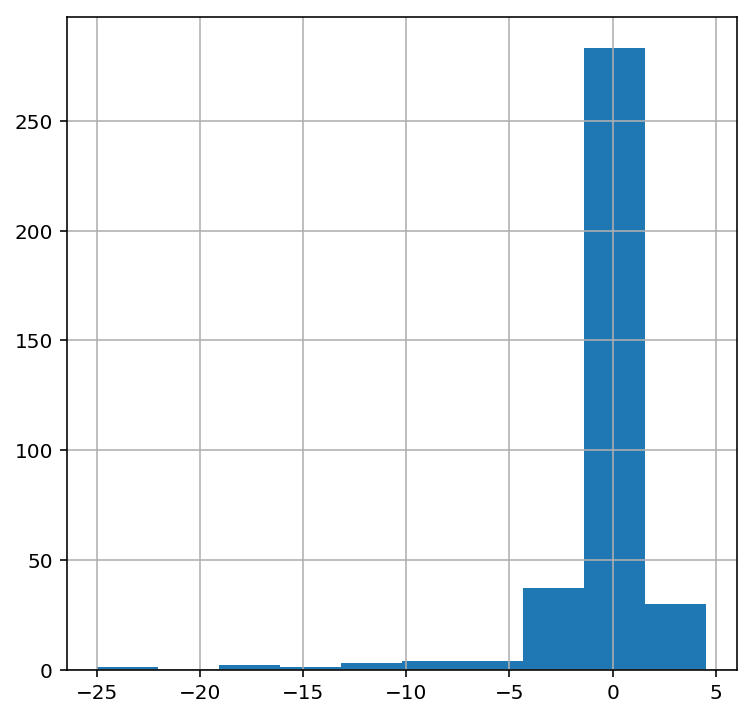

In [178]:
pd.Series(model.predict(X_val)[:,0]).hist()

In [179]:
import tensorflow as tf

In [181]:
def savecsv(test_prediction_np, filename="submission_tf_2lnn.csv"):
#     np.savetxt('submission_tf_titanic.csv', 
#            np.c_[range(1,len(x_test)+1),test_prediction_np], 
#            delimiter=',', 
#            header = 'PassengerId,Survived', 
#            comments = '', 
#            fmt='%d')
    StackingSubmission = pd.DataFrame({'Id': ids,'SalePrice': test_prediction_np })
    StackingSubmission.to_csv(filename, index=False)

In [361]:
def add_layer(inputs, input_size, output_size, activation_function=None):
    with tf.variable_scope("Weights"):
        Weights = tf.Variable(tf.random_normal(shape=[input_size, output_size]), name="weights")
    with tf.variable_scope("biases"):
        biases = tf.Variable(tf.zeros(shape=[1, output_size]) + 0.1, name="biases")
    with tf.name_scope("Wx_plus_b"):
        inputs = tf.to_float(inputs)
        Wx_plus_b = tf.matmul(inputs, Weights) + biases
    with tf.name_scope("dropout"):
        Wx_plus_b = tf.nn.dropout(Wx_plus_b, keep_prob=keep_prob_s)
    if activation_function is None:
        return Wx_plus_b
    else:
        with tf.name_scope("activation_function"):
            return activation_function(Wx_plus_b)

In [456]:
dimension = X_tr.shape[1]
graph = tf.Graph()  

with graph.as_default():
    tf_train_dataset = tf.placeholder(shape=[None, dimension], dtype=tf.float32, name="inputs")
    print("X_tr.shape", X_tr.shape)
    tf_train_labels = tf.placeholder(shape=[None, 1], dtype=tf.float32, name="y_true")
    keep_prob_s = tf.placeholder(dtype=tf.float32)
    with tf.name_scope("layer_1"):
        l1 = add_layer(tf_train_dataset, dimension, 50, activation_function=tf.nn.relu)
    with tf.name_scope("layer_2"):
        l2 = add_layer(l1, 50, 10,activation_function=tf.nn.relu)
    with tf.name_scope("y_pred"):
        pred = add_layer(l2, 10, 1)
    with tf.name_scope("loss"):
        loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf_train_labels - pred), axis=[1]))  # mse
    #     tf.summary.scalar("loss", tensor=loss)
    with tf.name_scope("train"):
        # train_op =tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
        optimizer = tf.train.AdamOptimizer(learning_rate=0.03).minimize(loss)

X_tr.shape (1022, 25)


In [457]:
num_steps = 40001
batch_size = 256 
print(type(X_tr))
X_tr_tf = X_tr
X_val_tf = X_val 
y_tr_tf = y_tr 
y_val_tf = y_val 

train_labels = np.reshape(y_tr_tf, [-1, 1])
val_labels = np.reshape(y_val_tf, [-1, 1])
with tf.Session(graph=graph) as session:
    # 这是一个一次性操作，可以确保参数按照我们在图中描述的初始化：矩阵的随机权重，偏差为零。
    # This is a one-time operation which ensures the parameters get initialized as
    # we described in the graph: random weights for the matrix, zeros for the biases. 
    tf.global_variables_initializer().run()
    offset = (step * batch_size) % (y_tr.shape[0] - batch_size)  
    batch_data = X_tr_tf[offset:(offset + batch_size), :]  
    batch_labels = train_labels[offset:(offset + batch_size), :]  
    
    
#     feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob_s: 0.5 }  
    feed_dict = {tf_train_dataset : X_tr_tf, tf_train_labels : train_labels, keep_prob_s: 0.5 }  
#     feed_dict = {tf_train_dataset : X_tr_tf, tf_train_labels : train_labels}  
#     feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}  
#     feed_dict_valid = {tf_train_dataset : X_val_tf, tf_train_labels : y_val_tf}  
#     feed_dict_valid = {tf_train_dataset : X_val_tf,  keep_prob_s: keep_prob}  
    feed_dict_test = {tf_train_dataset : X_test_new_ss,  keep_prob_s: 1.0}  
    print("X_tr_tf",X_tr_tf.shape)
    print("train_labels",train_labels.shape)
    print('Initialized')
    for step in range(num_steps):
#         _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
#         session.run([optimizer], feed_dict=feed_dict)
#         l = session.run(loss, feed_dict={tf_train_dataset : batch_data, tf_train_labels : batch_labels, keep_prob_s: 1.0})
        if step % 2000 == 0:
            print('Loss at step %d: %f' % (step, l))

    test_pred = session.run(pred, feed_dict=feed_dict_test)
    # 保存结果
    print("test_pred",test_pred)
    test_prediction_np = np.exp(test_pred)
    price = test_prediction_np.reshape(len(test_prediction_np))
    savecsv(price,"submission_tf_2lnn.csv")
    
print("Complete")

<class 'numpy.ndarray'>
X_tr_tf (1022, 25)
train_labels (1022, 1)
Initialized
Loss at step 0: 1162.712158


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Loss at step 2000: 0.061876
Loss at step 4000: 0.014480
Loss at step 6000: 0.077330
Loss at step 8000: 0.012511
Loss at step 10000: 0.041210
Loss at step 12000: 0.001429
Loss at step 14000: 0.012830
Loss at step 16000: 0.000978
Loss at step 18000: 0.023956
Loss at step 20000: 0.001442
Loss at step 22000: 0.008189
Loss at step 24000: 0.000623
Loss at step 26000: 0.001016
Loss at step 28000: 0.000935
Loss at step 30000: 0.000380
Loss at step 32000: 0.002715
Loss at step 34000: 0.000751
Loss at step 36000: 0.000385
Loss at step 38000: 0.001545
Loss at step 40000: 0.001503
test_pred [[ 11.81556892]
 [ 12.30144119]
 [ 12.45418453]
 ..., 
 [ 11.98832512]
 [ 11.27187634]
 [ 12.23567295]]
Complete


In [405]:

# 变厚矩阵
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


# 偏置
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# 卷积处理 变厚过程
def conv2d(x, W):
    # stride [1, x_movement, y_movement, 1] x_movement、y_movement就是步长
    # Must have strides[0] = strides[3] = 1 padding='SAME'表示卷积后长宽不变
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


# pool 长宽缩小一倍
def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')



In [451]:
graph = tf.Graph()  

with graph.as_default():
    # define placeholder for inputs to network
    xs = tf.placeholder(tf.float32, [None, 25])  # 原始数据的维度：25
    ys = tf.placeholder(tf.float32, [None, 1])  # 输出数据为维度：1

    keep_prob = tf.placeholder(tf.float32)  # dropout的比例

    x_image = tf.reshape(xs, [-1, 5, 5, 1])  # 原始数据16变成二维图片4*4
    ## conv1 layer ##第一卷积层
    W_conv1 = weight_variable([2, 2, 1, 32])  # patch 2x2, in size 1, out size 32,每个像素变成32个像素，就是变厚的过程
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)  # output size 2x2x32，长宽不变，高度为32的三维图像
    # h_pool1 = max_pool_2x2(h_conv1)     # output size 2x2x32 长宽缩小一倍

    ## conv2 layer ##第二卷积层
    W_conv2 = weight_variable([2, 2, 32, 64])  # patch 2x2, in size 32, out size 64
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2) + b_conv2)  # 输入第一层的处理结果 输出shape 4*4*64

    ## fc1 layer ##  full connection 全连接层
    W_fc1 = weight_variable([5 * 5 * 64, 512])  # 4x4 ，高度为64的三维图片，然后把它拉成512长的一维数组
    b_fc1 = bias_variable([512])

    h_pool2_flat = tf.reshape(h_conv2, [-1, 5 * 5 * 64])  # 把4*4，高度为64的三维图片拉成一维数组 降维处理
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)  # 把数组中扔掉比例为keep_prob的元素
    ## fc2 layer ## full connection
    W_fc2 = weight_variable([512, 1])  # 512长的一维数组压缩为长度为1的数组
    b_fc2 = bias_variable([1])  # 偏置
    # 最后的计算结果
    prediction = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    # prediction = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    # 计算 predition与y 差距 所用方法很简单就是用 suare()平方,sum()求和,mean()平均值
    cross_entropy = tf.reduce_mean(tf.reduce_sum(tf.square(ys - prediction), reduction_indices=[1]))
    # 0.01学习效率,minimize(loss)减小loss误差
    train_step = tf.train.AdamOptimizer(0.03).minimize(cross_entropy)


In [452]:

with tf.Session(graph=graph) as sess:
    # important step
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    sess.run(tf.global_variables_initializer())
    # 训练500次
    for i in range(200):

    #     feed_dict_test = {tf_train_dataset : X_test_new_ss}  
    #     feed_dict = {tf_train_dataset : X_tr_tf, tf_train_labels : train_labels, keep_prob_s: keep_prob }  
        sess.run(train_step, feed_dict={xs: X_tr_tf, ys: train_labels, keep_prob: 0.7})
        # 输出loss值
        print(i, '误差=',sess.run(cross_entropy, feed_dict={xs: X_tr_tf, ys: train_labels, keep_prob: 1.0}))  
    # 可视化
    prediction_value = sess.run(prediction, feed_dict={xs: X_test_new_ss, keep_prob: 1.0})
    print(prediction_value)
    prediction_value_np = np.exp(prediction_value)
    price = prediction_value_np.reshape(len(prediction_value_np))
    #     print("test_prediction_np",test_prediction_np[0])
    #     print("test_prediction_np.shpe",test_prediction_np.shape)
    #     print("x.shpe",x.shape)
    #     print("x",x)
    #     print("test_prediction_np.shape",test_prediction_np.shape)
    savecsv(price,"submission_tf_2lcnn.csv")

    print("Complete")
    ###画图###########################################################################
    # import matplotlib.pyplot as plt

    # fig = plt.figure(figsize=(20, 3))  # dpi参数指定绘图对象的分辨率，即每英寸多少个像素，缺省值为80
    # axes = fig.add_subplot(1, 1, 1)
    # line1, = axes.plot(range(len(prediction_value)), prediction_value, 'b--', label='cnn', linewidth=2)
    # line2,=axes.plot(range(len(gbr_pridict)), gbr_pridict, 'r--',label='优选参数')
    # line3, = axes.plot(range(len(test_y_disorder)), test_y_disorder, 'g', label='实际')

    # axes.grid()
    # fig.tight_layout()
    # plt.legend(handles=[line1, line2,line3])
    # plt.legend(handles=[line1, line3])
    # # plt.title('卷积神经网络')
    # plt.show()



0 误差= 65712.2
1 误差= 44.2559
2 误差= 169.45
3 误差= 151.3
4 误差= 144.467
5 误差= 141.549
6 误差= 140.529
7 误差= 139.768
8 误差= 138.6
9 误差= 136.776
10 误差= 134.157
11 误差= 130.857
12 误差= 127.19
13 误差= 123.099
14 误差= 118.591
15 误差= 113.663
16 误差= 108.243
17 误差= 102.338
18 误差= 95.9713
19 误差= 89.193
20 误差= 82.06
21 误差= 74.6182
22 误差= 66.9474
23 误差= 59.1434
24 误差= 51.3101
25 误差= 43.5698
26 误差= 36.0546
27 误差= 28.9058
28 误差= 22.2823
29 误差= 16.3222
30 误差= 11.1605
31 误差= 6.92094
32 误差= 3.6956
33 误差= 1.52092
34 误差= 0.382818
35 误差= 0.173181
36 误差= 0.715161
37 误差= 1.74707
38 误差= 2.99347
39 误差= 4.19068
40 误差= 5.10819
41 误差= 5.5782
42 误差= 5.62387
43 误差= 5.25919
44 误差= 4.57361
45 误差= 3.68486
46 误差= 2.74764
47 误差= 1.86788
48 误差= 1.1271
49 误差= 0.587033
50 误差= 0.264129
51 误差= 0.1479
52 误差= 0.20962
53 误差= 0.407478
54 误差= 0.701007
55 误差= 1.03796
56 误差= 1.37424
57 误差= 1.68062
58 误差= 1.92437
59 误差= 2.09261
60 误差= 2.17225
61 误差= 2.16847
62 误差= 2.09034
63 误差= 1.94935
64 误差= 1.75881
65 误差= 1.53923
66 误差= 1.3056
67 误差= 1.070

In [334]:
batch_size = 64  
regularation_param = 0.0001  
keep_prob = 0.8
graph = tf.Graph()  
num_labels = 2
hidden_nodes = 512


def compute_logits(data, weightss, biasess, dropout_vals=None):  
    temp = data  
    if dropout_vals:  
        for w,b,d in zip(weightss[:-1], biasess[:-1], dropout_vals[:-1]):  
            temp = tf.nn.relu_layer(tf.nn.dropout(temp, d), w, b)  
        temp = tf.matmul(temp, weightss[-1]) + biasess[-1]  
    else:  
        for w,b in zip(weightss[:-1], biasess[:-1]):  
            temp = tf.nn.relu_layer(temp, w, b)  
        temp = tf.matmul(temp, weightss[-1]) + biasess[-1]  
    return temp

with graph.as_default():
    # -----------------------------------------1
    # 输入 
    # placeholder 插入一个待初始化的张量占位符
    # 重要事项：这个张量被求值时会产生错误。 
    # 它的值必须在Session.run(), Tensor.eval() 或 Operation.run() 中使用feed_dict的这个可选参数来填充。
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, X_tr.shape[1]), name="tf_train_dataset")
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, 1), name="tf_train_labels")
    keep_prob_s = tf.placeholder(dtype=tf.float32)
    print("X_tr.shape[1])",X_tr.shape[1])
    # 创建一个常量张量
    tf_valid_dataset = tf.constant(X_val)
    tf_test_dataset = tf.constant(X_test)
    
    #转数据类型，f64->f32
    tf_train_dataset = tf.to_float(tf_train_dataset)
    tf_valid_dataset = tf.to_float(tf_valid_dataset)
    tf_test_dataset = tf.to_float(tf_test_dataset)
    
    # 变量
    # 梯度学习率
    # 初始的学习速率
    starter_learning_rate = 0.03 
    # 全局的step，与 decay_step 和 decay_rate一起决定了 learning rate的变化
    global_step = tf.Variable(0, trainable=False)
    # 衰减速度
    decay_steps = 50
    # 衰减系数
    decay_rate = 0.8
    # 如果staircase=True，那就表明每decay_steps次计算学习速率变化，更新原始学习速率.
    # 如果是False，那就是每一步都更新学习速率
    staircase = False
    # 指数衰减:法通过这个函数，可以先使用较大的学习率来快速得到一个比较优的解，然后随着迭代的继续逐步减小学习率，使得模型在训练后期更加稳定
    # 87.7% 仅仅指数衰减
    learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step,decay_steps,decay_rate,staircase)
    
    
    # 当你训练一个模型的时候，你使用变量去保存和更新参数。
    # 在Tensorflow中变量是内存缓冲区中保存的张量（tensor）
    
#     weights_end = tf.Variable(tf.truncated_normal([288, 1]))
#     biases_end = tf.Variable(tf.zeros([1]))
#     weights = tf.placeholder(shape=[288, 1], dtype=tf.float32, name="weights")
#     biases = tf.Variable(tf.zeros(shape=[1, 1]) + 0.1, name="biases")
    
    weights1 = tf.Variable(tf.truncated_normal([10, 10]))
    biases1 = tf.Variable(tf.zeros([10]))

    weights2 = tf.Variable(tf.truncated_normal([10, 1]))
    biases2 = tf.Variable(tf.zeros([1]))
    
    
    l1 = add_layer(X_tr, 10, 10, activation_function=tf.nn.relu)
    out = add_layer(l1, 10, 1)
    train_logits = out
    
#     print(X_val.dtype)
    l1 = add_layer(X_val, 10, 10, activation_function=tf.nn.relu)
    out = add_layer(l1, 10, 1)
    valid_logits = out
    
    l1 = add_layer(X_test_new_ss, 10, 10, activation_function=tf.nn.relu)
    out = add_layer(l1, 10, 1)
    test_logits = out
    
#     print(weights_end.shape)
#     print(biases_end.shape)
#     print(X_tr.shape)
    
    
    #DropOut
    drop = tf.nn.dropout(tf_train_dataset, keep_prob=keep_prob)
    
    # 训练计算.
#     train_logits = tf.matmul(tf_train_dataset, weights) + biases
#     valid_logits = tf.matmul(tf_valid_dataset, weights) + biases
#     test_logits = tf.matmul(tf_test_dataset, weights) + biases



#     train_logits = tf.add(tf.matmul(tf_train_dataset, weights1),biases1)
#     train_logits = tf.nn.relu(train_logits)
#     train_logits = tf.add(tf.matmul(train_logits,weights2),biases2)

#     valid_logits = tf.add(tf.matmul(tf_valid_dataset, weights1),biases1)
#     valid_logits = tf.nn.relu(valid_logits)
#     valid_logits = tf.add(tf.matmul(valid_logits,weights2),biases2)

#     test_logits = tf.add(tf.matmul(tf_test_dataset, weights1),biases1)
#     test_logits = tf.nn.relu(test_logits)
#     test_logits = tf.add(tf.matmul(test_logits,weights2),biases2)
    
    
    #加l2_loss
#     hpl2 =  regularation_param * (tf.nn.l2_loss(weights1)
#                                   + tf.nn.l2_loss(weights2)
#                                   + tf.nn.l2_loss(weights3)
#                                   + tf.nn.l2_loss(weights4)
#                                   + tf.nn.l2_loss(weights5)
#                                  )
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf_train_labels - train_logits), axis=[1]))
#     loss = tf.add(loss, hpl2)


    # 最优化.因为深度学习常见的是对于梯度的优化，也就是说，优化器最后其实就是各种对于梯度下降算法的优化。 
#     optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
#     optimizer = tf.train.GradientDescentOptimizer(0.02).minimize(loss, global_step=global_step)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)
    
    train_prediction = tf.nn.softmax(train_logits)
    valid_prediction = tf.nn.softmax(valid_logits)
    test_prediction = tf.nn.softmax(test_logits)

X_tr.shape[1]) 10


In [ ]:
    #DropOut
#     drop = tf.nn.dropout(tf_train_dataset, keep_prob=keep_prob)
    
    # 训练计算.
#     train_logits = tf.matmul(tf_train_dataset, weights) + biases
#     valid_logits = tf.matmul(tf_valid_dataset, weights) + biases
#     test_logits = tf.matmul(tf_test_dataset, weights) + biases

#     train_logits = tf.add(tf.matmul(tf_train_dataset, weights1),biases1)
#     train_logits = tf.nn.relu(train_logits)
#     train_logits = tf.add(tf.matmul(train_logits,weights2),biases2)

#     valid_logits = tf.add(tf.matmul(tf_valid_dataset, weights1),biases1)
#     valid_logits = tf.nn.relu(valid_logits)
#     valid_logits = tf.add(tf.matmul(valid_logits,weights2),biases2)

#     test_logits = tf.add(tf.matmul(tf_test_dataset, weights1),biases1)
#     test_logits = tf.nn.relu(test_logits)
#     test_logits = tf.add(tf.matmul(test_logits,weights2),biases2)

In [416]:
batch_size = 64  
regularation_param = 0.0001  
keep_prob = 0.1
num_labels = 2
hidden_nodes = 512
dimension = X_tr.shape[1]
l1out = 20
graph = tf.Graph()  

with graph.as_default():
    # -----------------------------------------1
    # 输入 
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, dimension), name="tf_train_dataset")
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, 1), name="tf_train_labels")
    keep_prob_s = tf.placeholder(dtype=tf.float32)
    print("X_tr.shape[1])",X_tr.shape[1])
    # 创建一个常量张量
    tf_valid_dataset = tf.constant(X_val)
    tf_test_dataset = tf.constant(X_test)
    
    #转数据类型，f64->f32
    tf_train_dataset = tf.to_float(tf_train_dataset)
    tf_valid_dataset = tf.to_float(tf_valid_dataset)
    tf_test_dataset = tf.to_float(tf_test_dataset)

    
    weights1 = tf.Variable(tf.truncated_normal([288, 10]))
    biases1 = tf.Variable(tf.zeros([10]))

    weights2 = tf.Variable(tf.truncated_normal([10, 1]))
    biases2 = tf.Variable(tf.zeros([1]))
    
    
    l1 = add_layer(tf_train_dataset, dimension, l1out, activation_function=tf.nn.relu)
    out = add_layer(l1, l1out, 1)
    train_logits = out
    
    l1 = add_layer(X_val, dimension, l1out, activation_function=tf.nn.relu)
    out = add_layer(l1, l1out, 1)
    valid_logits = out
    
    l1 = add_layer(X_test_new_ss, dimension, l1out, activation_function=tf.nn.relu)
    out = add_layer(l1, l1out, 1)
    test_logits = out
    
    # 问题出在计算损失函数使用的是tf_train_labels - train_logits，所以不会应用到 test 上，所以无法收敛
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf_train_labels - train_logits), axis=[1]))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.05).minimize(loss)
    
    train_prediction = tf.nn.softmax(train_logits)
    valid_prediction = tf.nn.softmax(valid_logits)
    test_prediction = tf.nn.softmax(test_logits)

X_tr.shape[1]) 25
